# Answers 
1. Create a model that predicts the dropoff_distance of an order, given some features about the
order. A model like this could then be fed into the logistics rider-scheduling algorithms.<br/>
    1. Please find most of the comments either in the readme.md, comment blocks and docstring
1. Propose some front-end features that might help reduce dropoff_distance.
    1. Common theme coming out of model explanability is call instructions and phone number are important. From EDA we observed there're high number of missing phone number and instructions. So a UI feature included which prompts user to put their number categorically should help bring down dropoff distance. 

In [107]:
import json
import pandas as pd
from pandas_profiling import ProfileReport
import pickle as pkl
from collections import defaultdict
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
import shap

In [108]:
import utils
import make_data

In [109]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Sample of 10k to reduce experimentation times

In [110]:
data_df = make_data.loadData(sample=True)

In [5]:
profile = ProfileReport(data_df, title="Delivery Data Report", explorative=True)

# EDA 
If you don't see the widget here. Refer to `data/processed_data/eda_report.html`

Observations
1. High cardinality for order_id, customer_id, timestamp, postal code, geohash. So these features need to be treated before use or should be ignored for modeling activity depending on what they bring to the table. 
    1. Geohash can be converted into 8 features of 1 bit each
    1. Time stamp can be converted into hour, day of the week, day of the month
    1. customer_id can be changed to # of historical orders made
1. High correlation between has_* fields. So, some dimentionality reduction might be helpful. 
1. Data is of one month. 

In [8]:
profile.to_file("../data/processed_data/eda_report.html")

Summarize dataset:   0%|          | 0/30 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
profile.to_widgets()

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

# Feature Engineering
1. Time feature engg
1. Geohash feature engg
1. Customer ID can be used as an an indicator of how frequently that person orders by taking the historical counts of order placed

In [111]:
model_config = utils.getConfig()

encode_features = model_config['encode_features']

train_data, test_data = make_data.trainTestSplit(data_df)

train_df = make_data.featureEngineering(train_data, 'treated_train_data_sample.pkl')
test_df = make_data.featureEngineering(test_data, 'treated_test_data_sample.pkl')

Looking for an existing pickle treated_train_data_sample.pkl
Looking for an existing pickle treated_test_data_sample.pkl


## Encoding

Label encoding geohash bits. <br/>
For tree based model label encoding will work fine. For other style of modeling one-hot would be a better choice

In [112]:
train_df[encode_features], test_df[encode_features] = make_data.labelEncoding(train_df, test_df, encode_features)

# MRD

1. As the data is of only one month. I'm ignoring the look-ahead bias in this activity. Ideally in the complete dataset. I'll sample the train and test data set in such a way that future data is the test data. The test data should be of enough length such that complete periodicity is captured. 
1. There're 31 days of data. Keeping the last week of the data as the holdout set. So we capture any weekly cyclic behaviour there might have. 

In [113]:
input_features = model_config['features']
target_feature = model_config['target']

In [114]:
X_train, y_train, X_test, y_test = train_df[input_features], train_df[target_feature], test_df[input_features], test_df[target_feature], 

# Modeling

Model chose is Random Forest. 
1. Some good features of RF is it has inherent feature selection capability. 
1. It can reduce the variance without a lot of tweaking involved.

Grid Search
Used grid search for hyperparameter search. 

Given more time would have tried advanced models such as gradient boosted regression trees, GBRT (XGBoost, LightGBM etc.). Hyperparameter search would be tricker in these and hence would have used Bayesian hyperparameter search.

### Base Model

In [115]:
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=42)

In [116]:
base_accuracy = model_evaluation.evaluate(base_model, X_test, y_test)

Model Performance
Accuracy: -344.79
R-squared: -0.86
Adjusted R-squared: -0.88


### Grid Search
Using a random subsample of 10k to do hyperparameter search due to compute resource constraint 

In [233]:
from sklearn.model_selection import GridSearchCV# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [80, 90, 100, 110, 120],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [10, 20, 50, 100, 200, 300]
}# Create a based model
rf = RandomForestRegressor()# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [234]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_
best_grid = grid_search.best_estimator_

Fitting 3 folds for each of 1080 candidates, totalling 3240 fits
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300; total time=   1.6s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200; total time=   1.0s
[CV] E

[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300; total time=   1.6s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300; total time=   1.6s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300; total time=   1.5s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300; total time=   1.4s
[CV] END bootstrap=True, max_depth=80, max_features=3, min_samples_leaf

[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   1.5s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples

[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300; total time=   1.6s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_l

[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300; total time=   1.5s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300; total time=   1.6s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_

[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_le

[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300; total time=   1.5s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_le

[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300; total time=   1.6s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf

[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300; total time=   1.8s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_s

[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200; total time=   1.2s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_s

[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300; total time=   1.5s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   1.3s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200; total time=   1.2s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samp

[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200; total time=   1.2s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_

[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_sam

[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300; total time=   1.6s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300; total time=   1.5s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300; total time=   1.4s
[CV] END bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=110, max_features=3, mi

[CV] END bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200; total time=   1.3s
[CV] END bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   1.2s
[CV] END bootstrap=True, max_depth=120, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=120, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=120, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=120, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=120, max_features=2, min_s

[CV] END bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300; total time=   2.0s
[CV] END bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200; total time=   1.2s
[CV] END bootstrap=True, max_depth=110, max_features=3, min_

[CV] END bootstrap=False, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200; total time=   1.4s
[CV] END bootstrap=False, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=20; total time=   0.2s
[CV] END bootstrap=False, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END bootstrap=False, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=10; total time=   0.1s
[CV] END bootstrap=False, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=20; total time=   0.1s
[CV] END bootstrap=False, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100; total time=   0.6s
[CV] END bootstrap=False, max_depth=90, max_features=2, min

[CV] END bootstrap=False, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300; total time=   2.4s
[CV] END bootstrap=False, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300; total time=   2.3s
[CV] END bootstrap=False, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300; total time=   2.3s
[CV] END bootstrap=False, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100; total time=   0.7s
[CV] END bootstrap=False, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300; total time=   2.2s
[CV] END bootstrap=False, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100; total time=   0.6s
[CV] END bootstrap=False, max_depth=90, max_features=2, min

[CV] END bootstrap=False, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300; total time=   2.2s
[CV] END bootstrap=False, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=20; total time=   0.2s
[CV] END bootstrap=False, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100; total time=   0.7s
[CV] END bootstrap=False, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=10; total time=   0.1s
[CV] END bootstrap=False, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   1.4s
[CV] END bootstrap=False, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=20; total time=   0.1s
[CV] END bootstrap=False, max_depth=90, max_features=2, min_sa

[CV] END bootstrap=False, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   1.3s
[CV] END bootstrap=False, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=10; total time=   0.1s
[CV] END bootstrap=False, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200; total time=   1.3s
[CV] END bootstrap=False, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   1.9s
[CV] END bootstrap=False, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10; total time=   0.1s
[CV] END bootstrap=False, max_depth=90, max_features=2, min_

[CV] END bootstrap=False, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=20; total time=   0.1s
[CV] END bootstrap=False, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100; total time=   0.7s
[CV] END bootstrap=False, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   0.1s
[CV] END bootstrap=False, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END bootstrap=False, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=20; total time=   0.2s
[CV] END bootstrap=False, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100; total time=   0.6s
[CV] END bootstrap=False, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=10; total time=   0.1s
[CV] END bootstrap=False, max_depth=90, max_features=2, min_sa

[CV] END bootstrap=False, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200; total time=   1.2s
[CV] END bootstrap=False, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   1.2s
[CV] END bootstrap=False, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   1.7s
[CV] END bootstrap=False, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100; total time=   0.8s
[CV] END bootstrap=False, max_depth=90, max_features=3, min_

[CV] END bootstrap=False, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200; total time=   1.5s
[CV] END bootstrap=False, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=10; total time=   0.1s
[CV] END bootstrap=False, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   1.5s
[CV] END bootstrap=False, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=20; total time=   0.1s
[CV] END bootstrap=False, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.7s
[CV] END bootstrap=False, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=10; total time=   0.1s
[CV] END bootstrap=False, max_depth=100, max_features=2, m

### Performance

In [247]:
print(json.dumps(model_evaluation.performanceMetrices(best_grid, X_test, y_test), indent=4))

{
    "accuracy(mape derived)": -190.57963570544263,
    "r2": -0.0107564180118227,
    "adjusted r2": -0.020984863824270006
}


In [253]:
grid_accuracy = model_evaluation.evaluate(best_grid, X_test, y_test)
change = ( 100 * (grid_accuracy - base_accuracy) / base_accuracy)
print(f'Improvement of {change:0.2f}%')

Model Performance
Accuracy: -190.58
R-squared: -0.01
Adjusted R-squared: -0.02
Improvement of 244.69%


Saving the best params.  

In [236]:
pkl.dump(grid_search.best_params_, open('../data/processed_data/rf_best_params.pkl', 'wb'))

# Running the best model params on complete dataset

In [34]:
data_df_full = make_data.loadData(sample=False)

In [92]:
model_config = utils.getConfig()
encode_features = model_config['encode_features']

train_data, test_data = make_data.trainTestSplit(data_df_full)
train_df = make_data.featureEngineering(train_data, 'treated_train_data.pkl')
test_df = make_data.featureEngineering(test_data, 'treated_test_data.pkl')

train_df[encode_features], test_df[encode_features] = make_data.labelEncoding(train_df, test_df, encode_features)

input_features = model_config['features']
target_feature = model_config['target']

X_train, y_train, X_test, y_test = train_df[input_features], train_df[target_feature], test_df[input_features], test_df[target_feature] 

Looking for an existing pickle treated_train_data.pkl
Looking for an existing pickle treated_test_data.pkl


In [97]:
best_params = pkl.load(open('../data/processed_data/rf_best_params.pkl', 'rb'))

model = RandomForestRegressor(**best_params)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=80, max_features=2, min_samples_leaf=5,
                      min_samples_split=12)

In [101]:
pkl.dump(model, open('../data/processed_data/large_model.pkl', 'wb'))

## Model Evaluation

In [98]:
y_pred = model.predict(X_test)

In [103]:
import model_evaluation

In [105]:
print(json.dumps(model_evaluation.performanceMetrices(model, X_test, y_test, y_pred), indent=4))

{
    "accuracy(mape derived)": -321.22947043044326,
    "r2": -9.241078556306912,
    "adjusted r2": -9.241480524774833,
    "rmse": 1249.0869627126706
}


In [106]:
model_evaluation.evaluate(model, X_train, y_train)

Model Performance
Accuracy: -279.13
R-squared: 0.14
Adjusted R-squared: 0.14


-279.12689014629603

## Model Explanability

In [41]:
model = pkl.load(open('../data/processed_data/large_model.pkl', 'rb'))

### Feature importance

Text(0.5, 0, 'Random Forest Feature Importance')

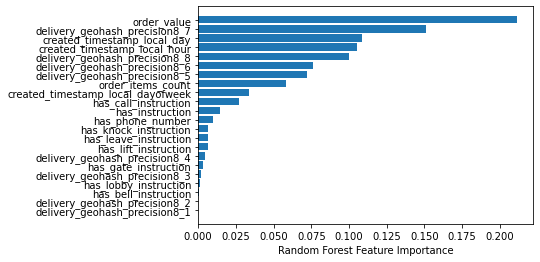

In [67]:
sorted_idx = base_model.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], base_model.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Feature importance using Shap values

In [75]:
rf = base_model
data_for_prediction = X_train.sample(1000)

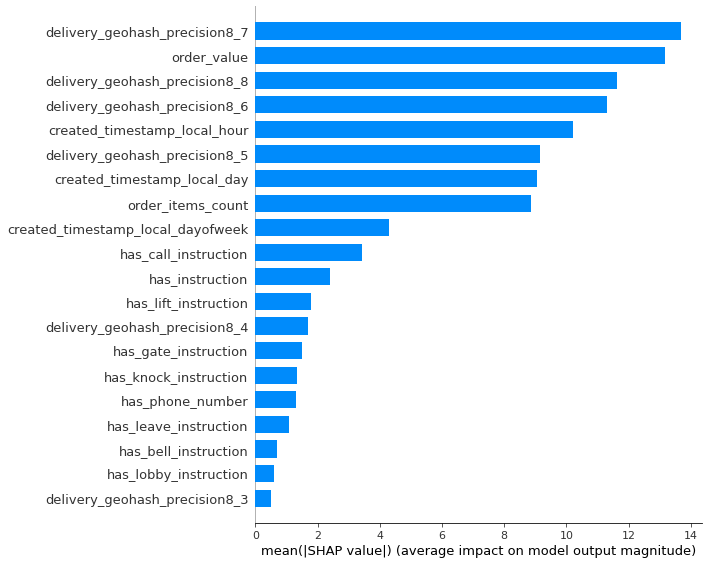

In [76]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(data_for_prediction)
shap.summary_plot(shap_values, data_for_prediction, plot_type="bar")

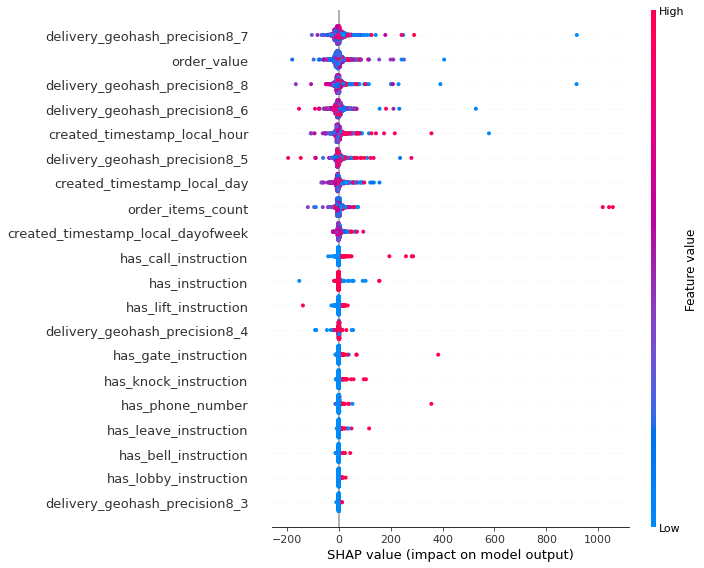

In [77]:
shap.summary_plot(shap_values, data_for_prediction)

In [83]:
shap.force_plot(explainer.expected_value, shap_values[100,:], data_for_prediction.iloc[100,:])

In [79]:
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

Ref:
1. https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
1. https://christophm.github.io/interpretable-ml-book/intro.html
1. https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html
1. https://mljar.com/blog/feature-importance-in-random-forest/
1. https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a